### EN COURS ###

In [50]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import ccxt
import json
import os

In [51]:
output_file = '/Users/maximemolin/Documents/Python/Backtest/crypto_data' + '/btc_usdt_data_1d.csv'

In [52]:
data = pd.read_csv(output_file ,parse_dates=['timestamp']).sort_index(ascending=False)
data

/var/folders/77/p5phw71x73d4c3n5nhtssc1r0000gn/T/ipykernel_94863/99041764.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(output_file ,parse_dates=['timestamp']).sort_index(ascending=False)


,timestamp,open,high,low,close,volume
1988,1686528000000,25925.54,26028.50,25602.11,25812.18,10287.094610
1987,1686441600000,25841.22,26206.88,25634.70,25925.55,30014.295950
1986,1686355200000,26477.80,26533.87,25358.00,25841.21,64944.601080
1985,1686268800000,26498.62,26783.33,26269.91,26477.81,27934.709700
1984,1686182400000,26339.34,26810.00,26210.00,26498.61,31075.510830
...,...,...,...,...,...,...
4,1515110400000,15059.56,17176.24,14600.00,16960.39,23251.491125
3,1515024000000,14919.51,15280.00,13918.04,15059.54,21329.649574
2,1514937600000,14690.00,15307.56,14150.00,14919.51,15905.667639
1,1514851200000,13382.16,15473.49,12890.02,14675.11,20078.092111


In [53]:
r = 1686528000000 - 1686441600000
print(r)

86400000


In [54]:
df = data

In [55]:
# Conversion de la colonne de timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%d')

/var/folders/77/p5phw71x73d4c3n5nhtssc1r0000gn/T/ipykernel_94863/3063227348.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%d')


In [59]:
class DCA_Leverage:
    def __init__(self, start_date, end_date, initial_USDT_balance, initial_BTC_balance, fee, leverage):
        self.start_date = start_date
        self.end_date = end_date
        self.initial_USDT_balance = initial_USDT_balance
        self.initial_BTC_balance = initial_BTC_balance
        self.exchange = ccxt.binance()# Pour run en condition réel
        self.exchange.load_markets()
        self.data = df
        self.fee = fee
        self.leverage = leverage
        self.trades = []
        self.portfolio_value_USDT = []
        self.portfolio_value_BTC = []
        self.liquidated_orders = []  # Liste des ordres liquidés
        self.total_long_fees = 0  # Total des frais pour les ordres longs
        self.num_long_trades = 0  # Nombre d'ordres longs exécutés
        self.num_liquidated_orders = 0  # Incrémenter le nombre d'ordres liquidés




    def fetch_historical_data(self):
        try:
            # Convertir la valeur de timestamp en type datetime64[ns]
            start_date1 = '2022-07-22'
            end_date1 = '2023-05-02'
            self.data = self.data[(self.data['timestamp'] >= start_date1) & (self.data['timestamp'] <= end_date1)]
        except:
            print(self.data)
            print(start_date1)

    def calculate_liquidation_threshold(self, buy_order_size, current_price):
        # Calcul du seuil de liquidation en tenant compte du levier
        return current_price / self.leverage

    def simulate_trading(self):
        USDT_balance = self.initial_USDT_balance
        BTC_balance = self.initial_BTC_balance

        for _, row in self.data.iterrows():
            current_price = row['close']
            num_day = len(df)
            usdt_allocation = self.initial_USDT_balance / num_day
            btc_allocation = 0
            
            # Calcul de la taille des ordres d'achat et de vente avec levier
            buy_order_size = usdt_allocation * self.leverage
            liquidation_threshold = self.calculate_liquidation_threshold(buy_order_size, current_price)

            # Condition pour acheter chaque jour (86400000 millisecondes = 1 jour)
            # Acheter du BTC
            btc_quantity = buy_order_size / current_price
            BTC_balance += btc_quantity
            USDT_balance -= buy_order_size
            self.trades.append({'timestamp': row['timestamp'], 'price': current_price, 'quantity': btc_quantity, 'type': 'buy'})
            self.num_long_trades += 1  # Incrémenter le nombre d'ordres longs
            self.total_long_fees += buy_order_size * self.fee  # Ajouter les frais des ordres longs

            # Vérifier si la liquidation s'est produite
            if current_price <= liquidation_threshold:
                self.liquidated_orders.append({'timestamp': row['timestamp'], 'price': current_price, 'quantity': btc_quantity, 'type': 'liquidation'})

            # Votre code pour la vente d'actifs va ici

            self.portfolio_value_USDT.append(USDT_balance)
            self.portfolio_value_BTC.append(BTC_balance)


    def run_backtest(self):
        self.fetch_historical_data()
        self.simulate_trading()
        portfolio_value_USDT_df = pd.DataFrame({'timestamp': self.data['timestamp'], 'value': self.portfolio_value_USDT})
        portfolio_value_BTC_df = pd.DataFrame({'timestamp': self.data['timestamp'], 'value': self.portfolio_value_BTC})
        average_long_fees = self.total_long_fees / self.num_long_trades  # Calcul des frais moyens des longs
        return pd.DataFrame(self.trades), portfolio_value_USDT_df, portfolio_value_BTC_df, self.liquidated_orders, average_long_fees


#Conversion des dates en ms
start_date1 = '2022-07-22'
date_obj = datetime.strptime(start_date1, '%Y-%m-%d')
timestamp1 = date_obj.timestamp() * 1000

timestamp_str = str(int(timestamp1))  # Convertir le timestamp en chaîne de caractères

end_date1 = '2023-05-19'
date_obj = datetime.strptime(end_date1, '%Y-%m-%d')
timestamp2 = date_obj.timestamp() * 1000

timestamp_str = str(int(timestamp2))  # Convertir le timestamp en chaîne de caractères
selected_close = data.loc[data['timestamp'] == start_date1, 'close'].values[0]
end_close = data.loc[data['timestamp'] == end_date1, 'close'].values[0]


initial_USDT_balance = 1000
buy_and_hold = initial_USDT_balance / selected_close
buy_and_hold_f = buy_and_hold * end_close
PNL =  buy_and_hold_f/ initial_USDT_balance

backtest = DCA_Leverage( start_date = timestamp1, end_date = timestamp2, initial_BTC_balance=0,  initial_USDT_balance = 1000, fee = 0.001, leverage = 2)
portfolio_value_USDT_df, portfolio_value_BTC_df = backtest.run_backtest()

# Conversion du portefeuille en BTC en valeur équivalente en USDT
btc_prices = backtest.data['close']
#portfolio_value_USDT_df['value'] = portfolio_value_BTC_df['value'] * btc_prices



ValueError: too many values to unpack (expected 2)

In [60]:
backtest.run_backtest()

ValueError: array length 570 does not match index length 285

NameError: name 'portfolio_value_USDT_df' is not defined

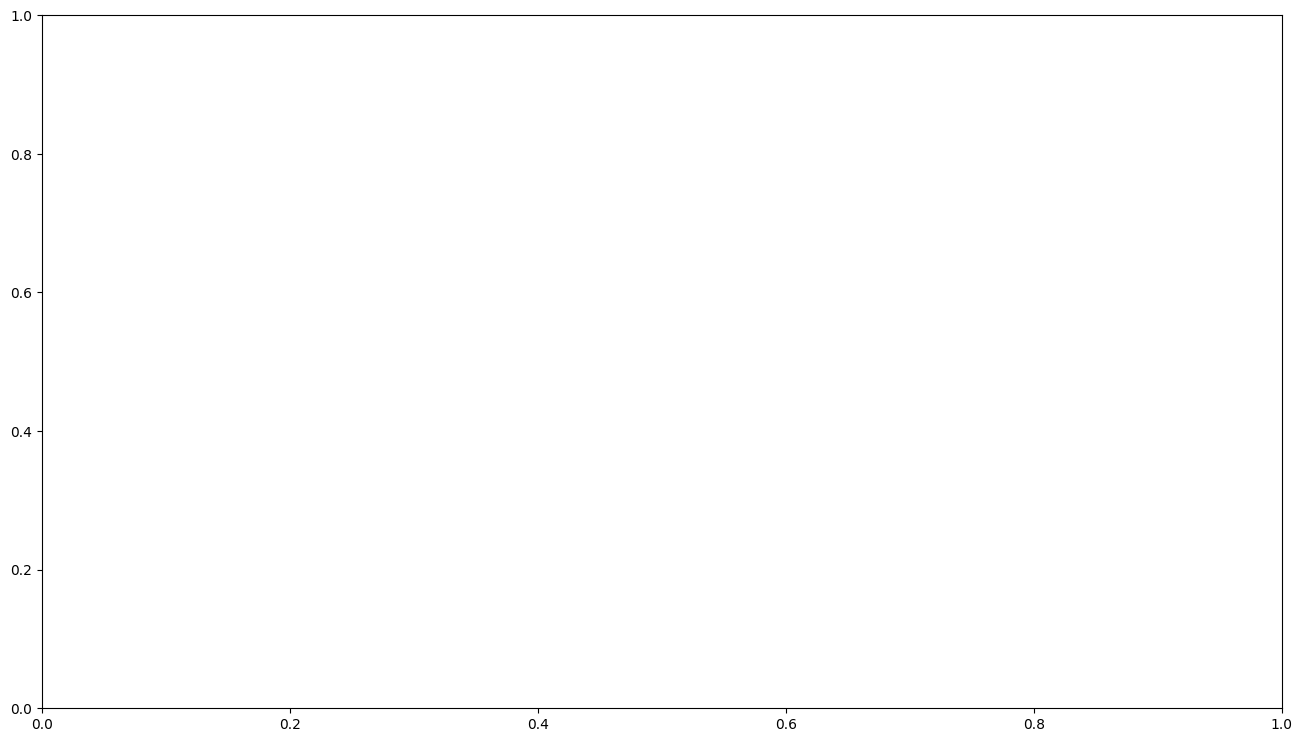

In [58]:

# Graphique de l'évolution de la valeur du portefeuille
fig, ax = plt.subplots(figsize=(16,9))

de = portfolio_value_USDT_df[portfolio_value_USDT_df.value>0]
ax.plot_date(de['timestamp'], de['value'], '-')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (USDT)')
ax.set_title('Portfolio Value Over Time (USDT)')
#ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid(True)
plt.ylim()
plt.show()



# Graphique de l'évolution de la valeur du portefeuille en BTC
fig, ax = plt.subplots(figsize=(16,9))
df = portfolio_value_BTC_df[portfolio_value_BTC_df.value>0]
ax.plot(df['timestamp'], df['value'], linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Crypto)')
ax.set_title('Portfolio Value Over Time (Crypto)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid(True)
plt.ylim()
plt.xticks(rotation=45)
plt.show()

last_portfolio_value = portfolio_value_USDT_df['value'].iloc[-1]  # Récupère la dernière valeur du portefeuille']
PNL_wallet = last_portfolio_value/initial_USDT_balance

print('quantité de Crypto BAH' , buy_and_hold)
print('quantité de USDT BAH' , buy_and_hold_f)
print('PNL du BAH' , PNL)
print('dernière valeur du wallet' , last_portfolio_value)
print('PNL du wallet' , PNL_wallet)